In [1]:
# Standard libraries
import sys
import time

# Third party libraries
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
import scipy.ndimage
from scipy.ndimage import median_filter
from sklearn.neighbors import KernelDensity

# Our libraries
sys.path.append('../../')
from gui.gui_shared import auto_contrast

## Functions

In [2]:
def readTifWrapper(i, file_name):
    """
    i - index for parallel processing
    file_name - file name to open
    """
    image = readTifSection(str(file_name))
    return [i, image]


def readTifSection(file_path):
    """
    Read tif section image using SITK
    """
    image = sitk.ReadImage(str(file_path))
    image = sitk.GetArrayFromImage(image)
    image[image < 0] = 0
    image = image.T
    image = np.flip(image, axis=0)
    image = np.flip(image, axis=1)
    image  = np.squeeze(image)
    return image


def n4_bias_correction(img, alpha=1, shrink_factor=25, show=False):
    """
    N4 bias correction
    """
    # Get contrast image for mask
    contrast_img = auto_contrast(img, alpha=alpha)
    
    # Create the brain tissue mask
    mask_img = sitk.GetImageFromArray(contrast_img)
    mask_img = sitk.RescaleIntensity(mask_img, 0, 255)
    mask_img = sitk.LiThreshold(mask_img, 0, 1)

    # Use the raw image and convert it to float32
    raw_img = sitk.GetImageFromArray(img.copy())
    raw_img = sitk.Cast(raw_img, sitk.sitkFloat32)

    # Downsample it for bias correction
    inputImage = raw_img
    if shrink_factor > 1:
        inputImage = sitk.Shrink( raw_img, [ shrink_factor ] * raw_img.GetDimension() ) #2
        maskImage = sitk.Shrink( mask_img, [ shrink_factor ] * inputImage.GetDimension() ) #3

    # Run bias correction
    start_time = time.time()
    bias_corrector = sitk.N4BiasFieldCorrectionImageFilter()
    corrected = bias_corrector.Execute(inputImage, maskImage)
    
    # Apply bias correction to full resolution image
    log_bias_field = bias_corrector.GetLogBiasFieldAsImage(raw_img)
    corrected_image_full_resolution = raw_img / sitk.Exp(log_bias_field)
    end_time = time.time()
    corrected_image_full_resolution = sitk.GetArrayFromImage(corrected_image_full_resolution)
    
    # Show the process if True
    if show:
        print(f"Time taken for bias correction: {end_time - start_time:.2f} seconds")
        
        # Show the brain tissue mask
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(sitk.GetArrayFromImage(mask_img), cmap='gray')
        plt.title(f"Full resolution brain mask")
        plt.subplot(1, 2, 2)
        plt.imshow(sitk.GetArrayFromImage(maskImage), cmap='gray')
        plt.title(f"Downsampled brain mask (shrink factor={shrink_factor})")
        plt.show()
        
        # Show the log bias field
        plt.figure(figsize=(10, 5))
        plt.imshow(sitk.GetArrayFromImage(log_bias_field))
        plt.colorbar()
        plt.title(f"Log bias field")
        plt.show()

        # Show the corrected bias field image
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Original raw image")
        plt.subplot(1, 2, 2)
        plt.imshow(corrected_image_full_resolution, cmap='gray')
        plt.title(f"Corrected bias raw image")
        plt.show()

        # Increase the contrast of the corrected image and show side-by-side
        preview_alpha = 0.25
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        contrast_comparison = auto_contrast(img, alpha=preview_alpha)
        plt.imshow(contrast_comparison, cmap='gray')
        plt.title(f"Original contrast image (alpha={preview_alpha})")
        plt.subplot(1, 2, 2)
        corrected_bias_contrast = auto_contrast(corrected_image_full_resolution, alpha=preview_alpha)
        plt.imshow(corrected_bias_contrast, cmap='gray')
        plt.title(f"Corrected bias contrast image (alpha={preview_alpha})")
        plt.show()
        
    return corrected_image_full_resolution


def show_crop(img, points=None, x_crop=[6100, 7600], y_crop=[2450, 3300], 
              title="Image", cmap='gray', colorbar=False):
    """
    Show the crop of the image
    """
    plt.figure(figsize=(10, 5))
    plt.imshow(img, cmap=cmap)
    if points is not None:
        for point in points:
            plt.plot(point[1], point[0], 'ro', markersize=1)
    plt.title(title)
    if x_crop is not None:
        plt.xlim(x_crop)
    if y_crop is not None:
        plt.ylim(y_crop[::-1])
    if colorbar:
        plt.colorbar()
    plt.show()

### Load in tiff data

Brain shape: (8716, 11236)
Ground truth (section 140) shape: (66, 2)


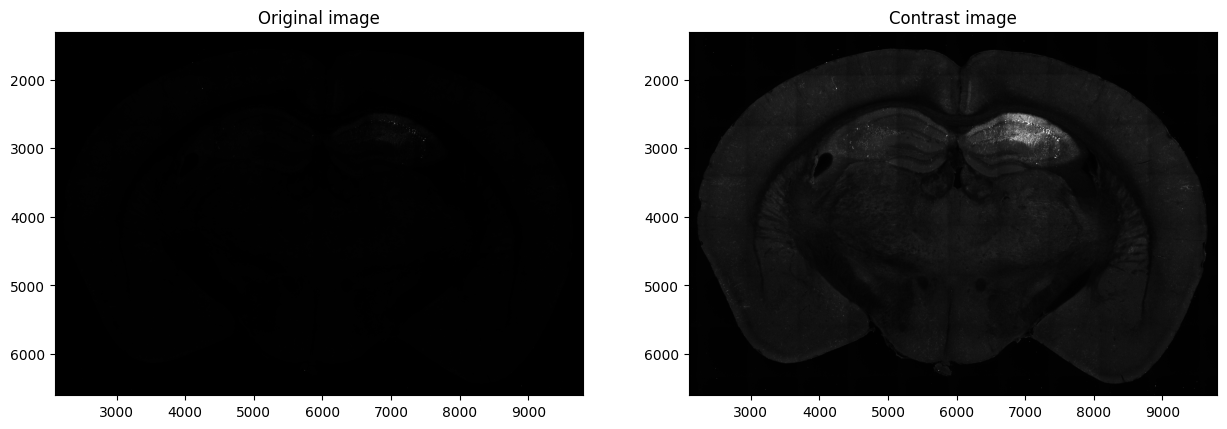

In [3]:
# Parameters for loading in the data
img_path = "/media/data/u01/B0039/stitched_ch0/230628_B0039_PG_U01_280-0140_1_0.tif"
gt140_path = "/media/data/u01/B0039/red_section140_counts_240930_PG/red_section140_counts_240930_PG.txt"

# Load in the images
img = readTifSection(img_path)
print("Brain shape:", img.shape)

gt_points = np.loadtxt(gt140_path, skiprows=2)
gt_points = gt_points[:, 1:]  # Remove section index row
print("Ground truth (section 140) shape:", gt_points.shape)

# Contrast section
contrast_img = auto_contrast(img, alpha=0.1)

# Plot the image and contrast image
x_boundary = (2100, 9800)  # Crop out most of the background
y_boundary = (1300, 6600)
x_dca1_boundary = (6100, 7600)  # Crop the section to the region of interest
y_dca1_boundary = (2450, 3300)
x_roi_boundary = (7100, 7400)  # Crop the section to the region of interest
y_roi_boundary = (2600, 2900)

plt.figure(figsize=(15, 5))  # 20, 10
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title(f"Original image")
plt.xlim(x_boundary)
plt.ylim(y_boundary[::-1])
plt.subplot(1, 2, 2)

plt.imshow(contrast_img, cmap='gray')
plt.title(f"Contrast image")
plt.xlim(x_boundary)
plt.ylim(y_boundary[::-1])
plt.show()

Perform N4 bias correction

https://medium.com/@alexandro.ramr777/how-to-do-bias-field-correction-with-python-156b9d51dd79

Original image stats:
0 31877
17.0
66.66915517812917
N4 bias corrected image stats:
0.0 30047.967716928382
18.40305573876823
65.20032037938365


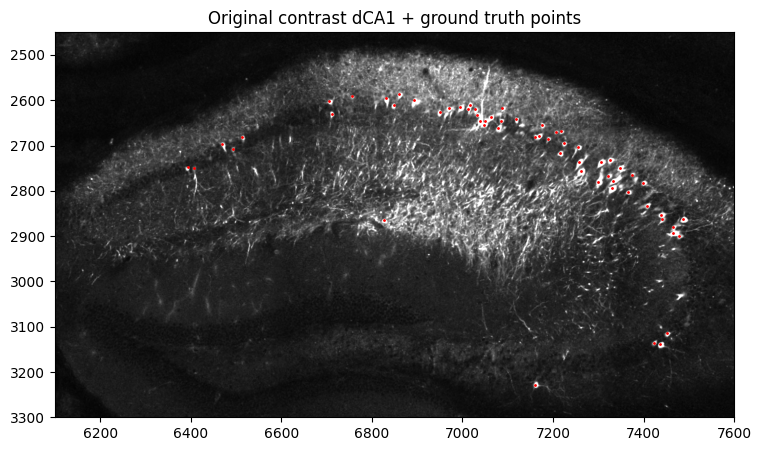

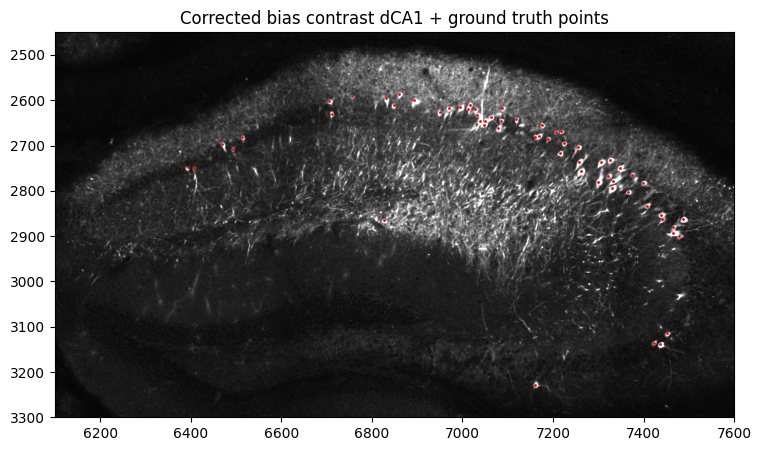

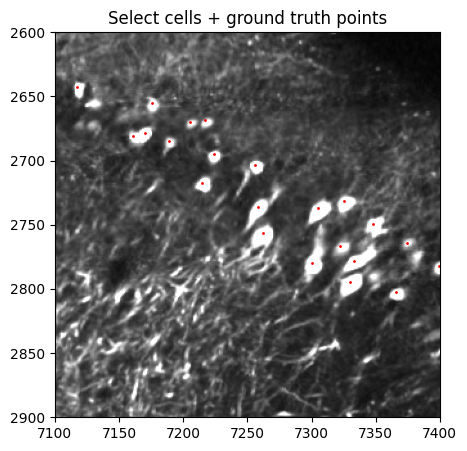

In [4]:
corrected_bias_img = n4_bias_correction(img, alpha=1, shrink_factor=10, show=False)

print("Original image stats:")
print(np.min(img), np.max(img))
print(np.median(img))
print(np.mean(img))

print("N4 bias corrected image stats:")
print(np.min(corrected_bias_img), np.max(corrected_bias_img))
print(np.median(corrected_bias_img))
print(np.mean(corrected_bias_img))

contrast_corrected_bias_img = auto_contrast(corrected_bias_img, alpha=0.1)
show_crop(contrast_img, points=gt_points, title="Original contrast dCA1 + ground truth points")
show_crop(contrast_corrected_bias_img, points=gt_points, title="Corrected bias contrast dCA1 + ground truth points")
show_crop(contrast_corrected_bias_img, points=gt_points, x_crop=x_roi_boundary, y_crop=y_roi_boundary, title="Select cells + ground truth points")

### Median filter

N4 bias corrected image stats:
Min: 0.0 Max: 30047.967716928382
Median: 18.40305573876823
Mean: 65.20032037938365

Median filtered image stats:
Min: 0.0 Max: 25193.603518968393
Median: 17.627450899646366
Mean: 63.983521536105535


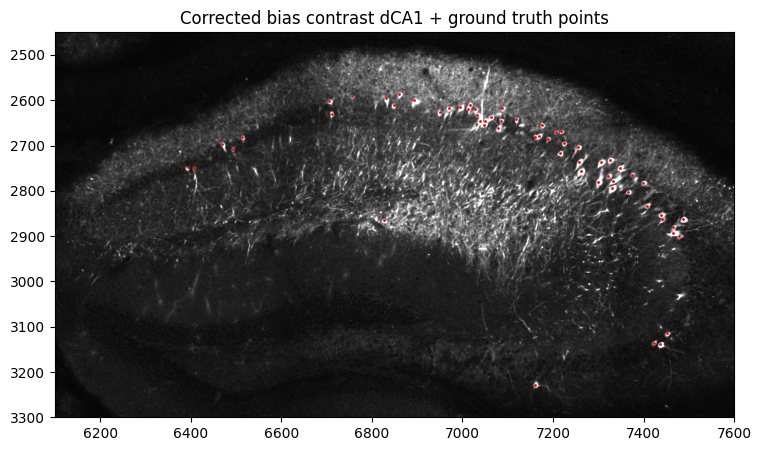

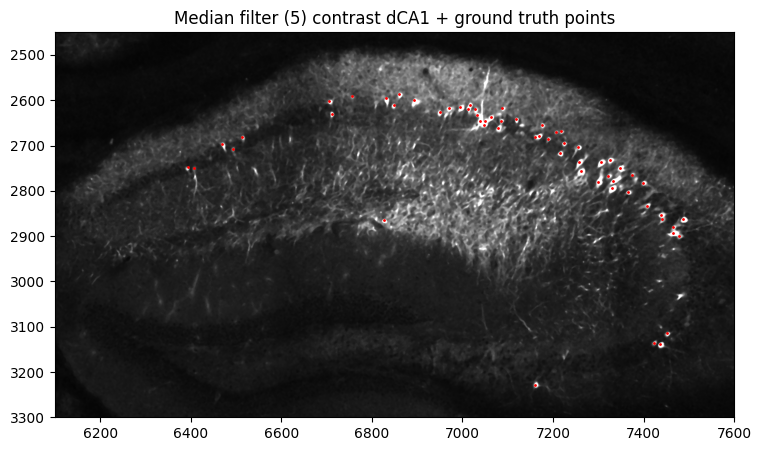

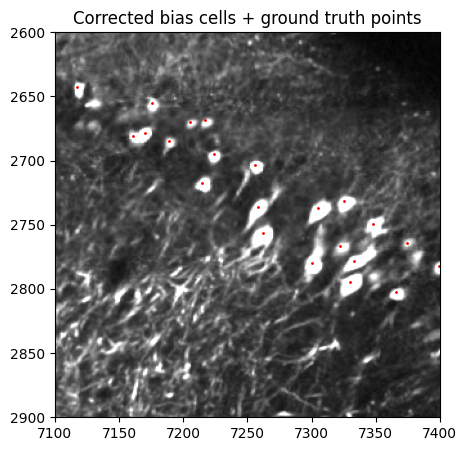

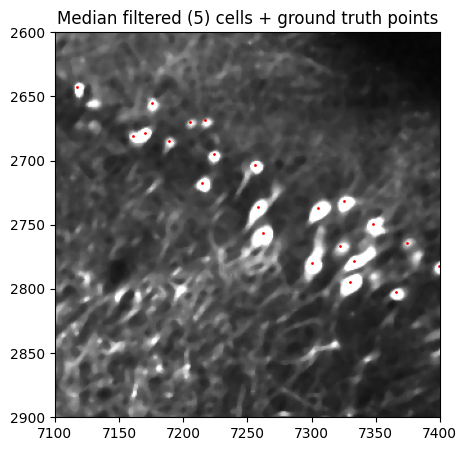

In [5]:
median_filter_size = 5

# Run median filter
median_filtered_img = median_filter(corrected_bias_img.copy(), size=median_filter_size)

print("N4 bias corrected image stats:")
print("Min:", np.min(corrected_bias_img), "Max:", np.max(corrected_bias_img))
print("Median:", np.median(corrected_bias_img))
print("Mean:", np.mean(corrected_bias_img))

print("\nMedian filtered image stats:")
print("Min:", np.min(median_filtered_img), "Max:", np.max(median_filtered_img))
print("Median:", np.median(median_filtered_img))
print("Mean:", np.mean(median_filtered_img))

contrast_median_filtered_img = auto_contrast(median_filtered_img, alpha=0.1)
show_crop(contrast_corrected_bias_img, points=gt_points, title="Corrected bias contrast dCA1 + ground truth points")
show_crop(contrast_median_filtered_img, points=gt_points, title=f"Median filter ({median_filter_size}) contrast dCA1 + ground truth points")
show_crop(contrast_corrected_bias_img, points=gt_points, x_crop=x_roi_boundary, y_crop=y_roi_boundary, title="Corrected bias cells + ground truth points")
show_crop(contrast_median_filtered_img, points=gt_points, x_crop=x_roi_boundary, y_crop=y_roi_boundary, 
          title=f"Median filtered ({median_filter_size}) cells + ground truth points")

### Gaussian filter

Median filtered image stats:
Min: 0.0 Max: 25193.603518968393
Median: 17.627450899646366
Mean: 63.983521536105535

Gaussian filtered image stats:
Min: 0.0 Max: 25193.601048856446
Median: 17.627451017744843
Mean: 63.983521536105954


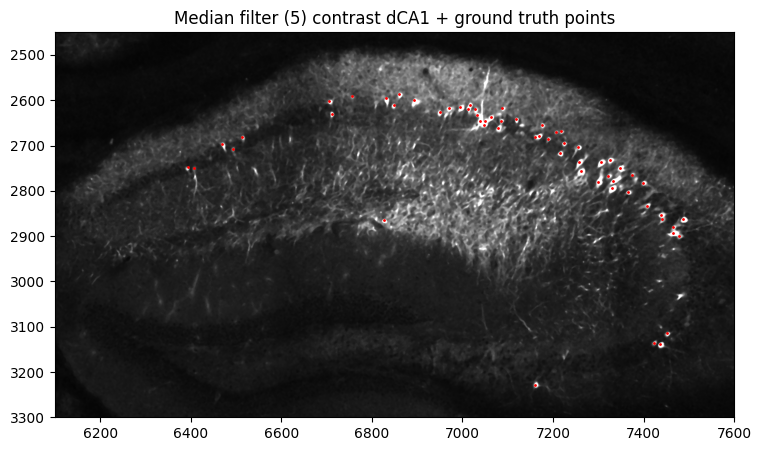

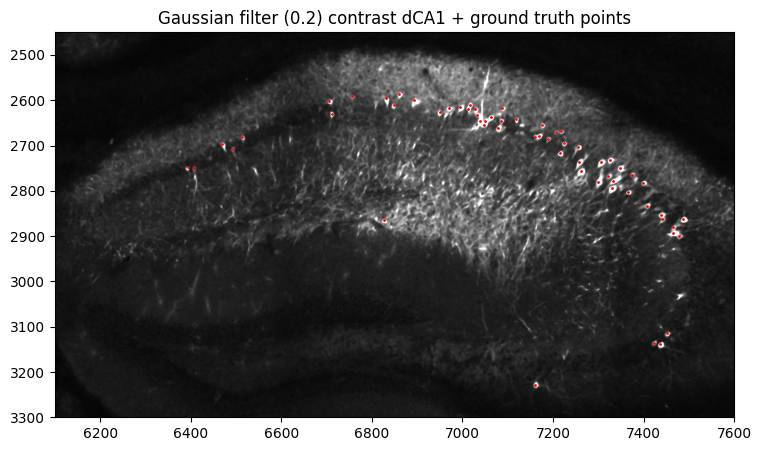

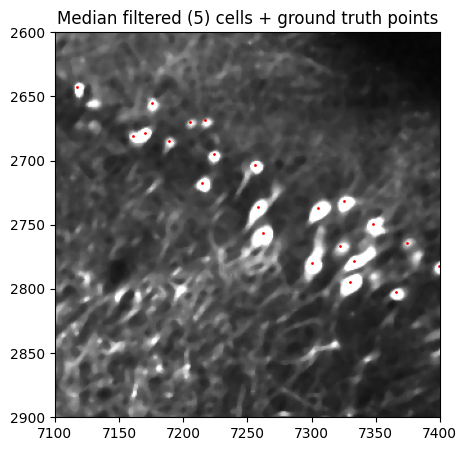

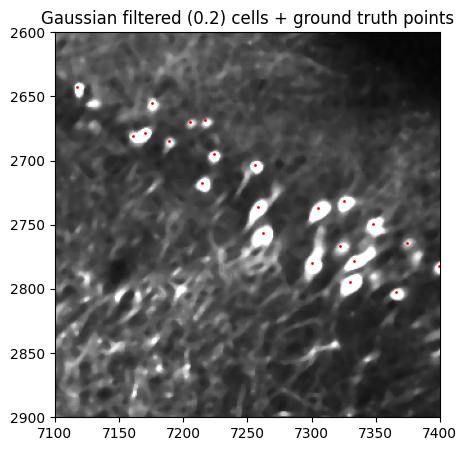

In [6]:
gaussian_sigma = 0.2

# Run gaussian filter
gaussian_filtered_img = scipy.ndimage.gaussian_filter(median_filtered_img.copy(), sigma=gaussian_sigma)

print("Median filtered image stats:")
print("Min:", np.min(median_filtered_img), "Max:", np.max(median_filtered_img))
print("Median:", np.median(median_filtered_img))
print("Mean:", np.mean(median_filtered_img))

print("\nGaussian filtered image stats:")
print("Min:", np.min(gaussian_filtered_img), "Max:", np.max(gaussian_filtered_img))
print("Median:", np.median(gaussian_filtered_img))
print("Mean:", np.mean(gaussian_filtered_img))

contrast_gaussian_filtered_img = auto_contrast(gaussian_filtered_img, alpha=0.1)
show_crop(contrast_median_filtered_img, points=gt_points, title=f"Median filter ({median_filter_size}) contrast dCA1 + ground truth points")
show_crop(contrast_gaussian_filtered_img, points=gt_points, title=f"Gaussian filter ({gaussian_sigma}) contrast dCA1 + ground truth points")
show_crop(contrast_median_filtered_img, points=gt_points, x_crop=x_roi_boundary, y_crop=y_roi_boundary, 
          title=f"Median filtered ({median_filter_size}) cells + ground truth points")
show_crop(contrast_gaussian_filtered_img, points=gt_points, x_crop=x_roi_boundary, y_crop=y_roi_boundary, 
          title=f"Gaussian filtered ({gaussian_sigma}) cells + ground truth points")

### Laplacian filter

Gaussian filtered image stats:
Min: 0.0 Max: 25193.601048856446
Median: 17.627451017744843
Mean: 63.983521536105954

Laplacian image stats:
Min: -18658.63233002237 Max: 12931.279365740587
Median: 0.0
Mean: -2.1930594491764025e-18


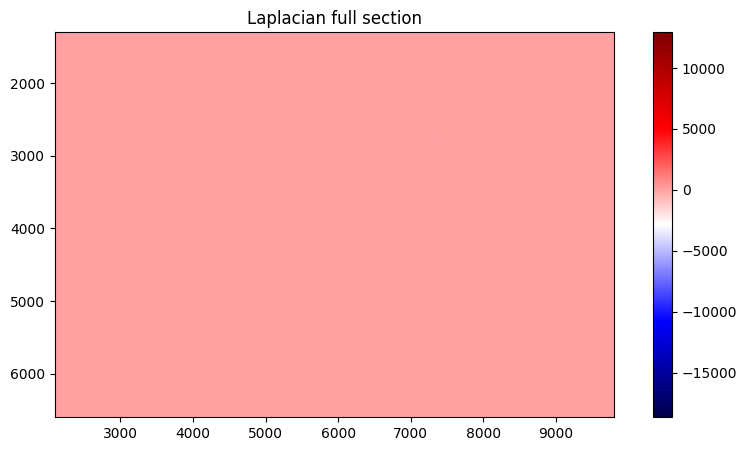

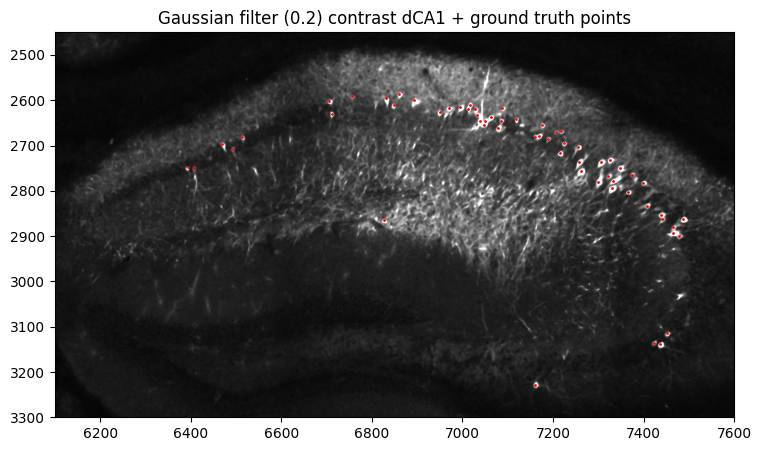

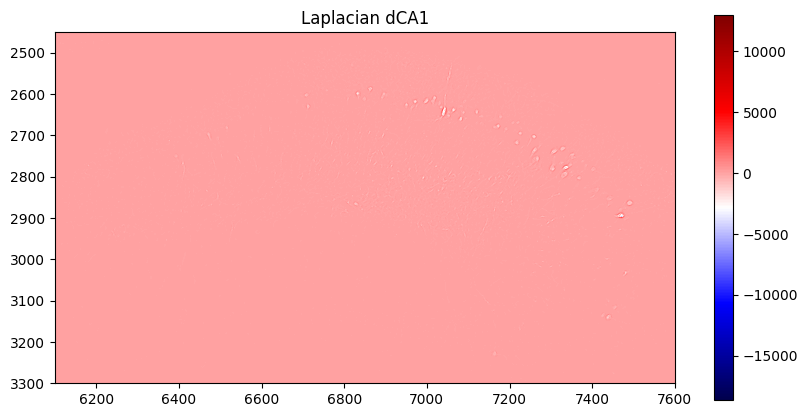

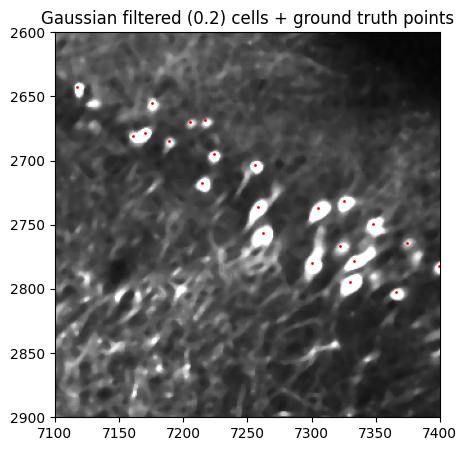

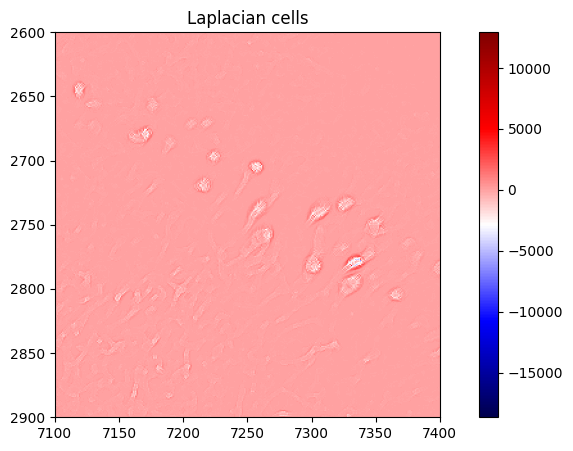

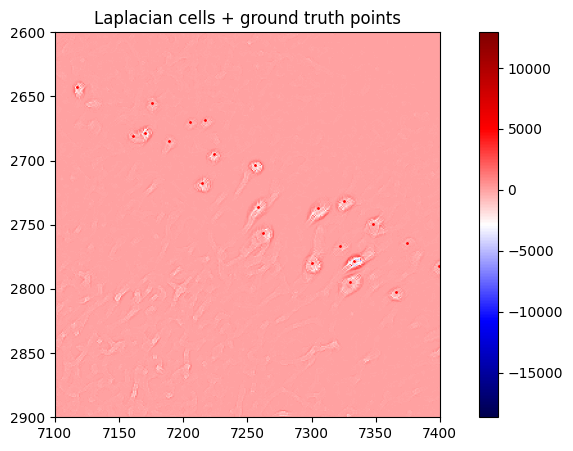

In [7]:
# Run Laplacian
laplacian_img = scipy.ndimage.laplace(gaussian_filtered_img.copy())

print("Gaussian filtered image stats:")
print("Min:", np.min(gaussian_filtered_img), "Max:", np.max(gaussian_filtered_img))
print("Median:", np.median(gaussian_filtered_img))
print("Mean:", np.mean(gaussian_filtered_img))

print("\nLaplacian image stats:")
print("Min:", np.min(laplacian_img), "Max:", np.max(laplacian_img))
print("Median:", np.median(laplacian_img))
print("Mean:", np.mean(laplacian_img))

show_crop(laplacian_img, x_crop=x_boundary, y_crop=y_boundary, title="Laplacian full section", cmap='seismic', colorbar=True)
show_crop(contrast_gaussian_filtered_img, points=gt_points, title=f"Gaussian filter ({gaussian_sigma}) contrast dCA1 + ground truth points")
show_crop(laplacian_img, title=f"Laplacian dCA1", cmap='seismic', colorbar=True)
show_crop(contrast_gaussian_filtered_img, points=gt_points, x_crop=x_roi_boundary, y_crop=y_roi_boundary, 
          title=f"Gaussian filtered ({gaussian_sigma}) cells + ground truth points")
show_crop(laplacian_img, x_crop=x_roi_boundary, y_crop=y_roi_boundary, title=f"Laplacian cells", cmap='seismic', colorbar=True)
show_crop(laplacian_img, points=gt_points, x_crop=x_roi_boundary, y_crop=y_roi_boundary, title=f"Laplacian cells + ground truth points", 
          cmap='seismic', colorbar=True)

### Thresholding

Laplacian mean: -2.1930594491764025e-18
Laplacian std: 19.952230163374004
Threshold value: 199.52230163374003


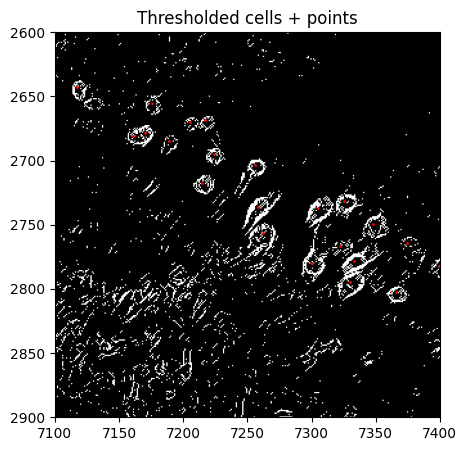

In [8]:
laplacian_mean = np.mean(laplacian_img)
print("Laplacian mean:", laplacian_mean)
laplacian_std = np.std(laplacian_img)
print("Laplacian std:", laplacian_std)

threshold_value = laplacian_mean + 10 * laplacian_std
print("Threshold value:", threshold_value)

thresholded_img = np.where(laplacian_img > threshold_value, 1, 0).astype(bool)

show_crop(thresholded_img, points=gt_points, x_crop=x_roi_boundary, y_crop=y_roi_boundary, title=f"Thresholded cells + points", cmap='gray')

Gaussian image mean: 63.983521536105954
Gaussian image std: 105.6273000714788
Threshold value: 2176.5295229656817


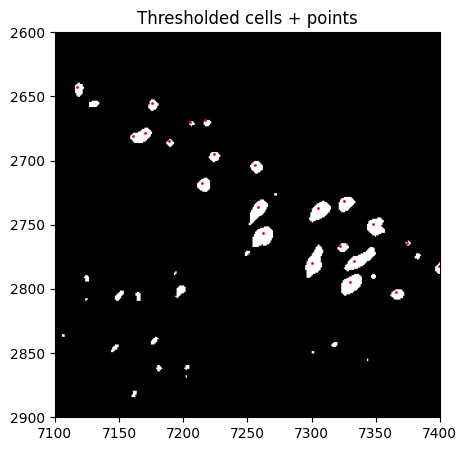

In [9]:
gaussian_img_mean = np.mean(gaussian_filtered_img)
print("Gaussian image mean:", gaussian_img_mean)
gaussian_img_std = np.std(gaussian_filtered_img)
print("Gaussian image std:", gaussian_img_std)

threshold_value = gaussian_img_mean + 20 * gaussian_img_std
print("Threshold value:", threshold_value)

thresholded_img = np.where(gaussian_filtered_img > threshold_value, 1, 0).astype(bool)

show_crop(thresholded_img, points=gt_points, x_crop=x_roi_boundary, y_crop=y_roi_boundary, title=f"Thresholded cells + points", cmap='gray')

[[2601 7043]
 [2601 7044]
 [2602 7042]
 ...
 [2666 7020]
 [2666 7021]
 [2667 7019]]
Min y: 2601
Max y: 2667
Min x: 7019
Max x: 7068


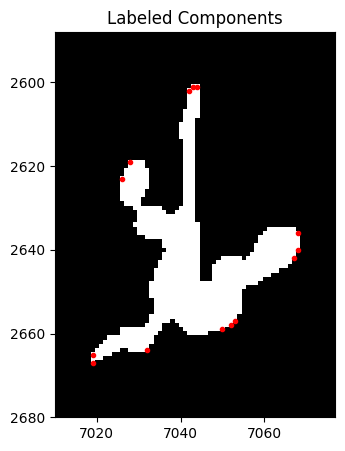

In [10]:
from skimage.measure import label, regionprops

# Label connected components
labeled_image = label(thresholded_img)

# Get properties of labeled regions
regions = regionprops(labeled_image)

# Find the index of the biggest connected component
max_area = 0
max_area_label = 0
for region in regions:
    if region.area > max_area:
        max_area = region.area
        max_area_label = region.label
        
# Extract the binary image for the biggest connected component
def get_component_binary_image(labeled_image, component_index):
    """
    Extract the binary image for a specific connected component index.
    
    Parameters:
    - labeled_image: Labeled image with connected components.
    - component_index: Index of the connected component to extract.
    
    Returns:
    - component_binary_image: Binary image of the extracted component.
    """
    component_binary_image = (labeled_image == component_index).astype(np.uint8)
    return component_binary_image

biggest_component_binary_image = get_component_binary_image(labeled_image, max_area_label)
np.save("data/branching_component.npy", biggest_component_binary_image)

from scipy.spatial import Delaunay, ConvexHull
# Extract the coordinates of the foreground pixels
points = np.column_stack(np.nonzero(biggest_component_binary_image))
# Compute the convex hull
hull = ConvexHull(points)
# Get the coordinates of the points on the convex hull
hull_points = points[hull.vertices]

print(points)
min_y = np.min(points[:, 0])
max_y = np.max(points[:, 0])
min_x = np.min(points[:, 1])
max_x = np.max(points[:, 1])
x_spacing = int((max_x - min_x) * 0.2)
y_spacing = int((max_y - min_y) * 0.2)

print("Min y:", min_y)
print("Max y:", max_y)
print("Min x:", min_x)
print("Max x:", max_x)

x_hull_lim = (min_x - x_spacing, max_x + x_spacing)
y_hull_lim = (max_y + y_spacing, min_y - y_spacing)

# Visualize the binary image and labeled components
plt.figure(figsize=(10, 5))
plt.imshow(biggest_component_binary_image, cmap='gray')
plt.title('Labeled Components')
plt.xlim(x_hull_lim)
plt.ylim(y_hull_lim)
for pt in hull_points:
    plt.plot(pt[1], pt[0], 'ro', markersize=3)
plt.show()






## Cell class

In [160]:
from scipy.spatial import Delaunay, ConvexHull
from skimage.draw import polygon, ellipse
from matplotlib.colors import ListedColormap
from scipy.spatial.distance import cdist
import pickle
import math
from skimage.draw import ellipse_perimeter
import cv2
from skimage.measure import find_contours
from matplotlib.lines import Line2D


class Cell:
    def __init__(self, image, z=None, index=None):
        self.image = image
        self.z = z
        self.index = index
        
    
    def get_area(self):
        """
        Compute the area of the cell image.
        
        Returns:
        - area: Area of the cell.
        """
        return np.sum(self.image)
    
    
    def get_centroid(self):
        """
        Compute the centroid of the cell image.
        
        Returns:
        - centroid: Tuple representing the (row, column) coordinates of the centroid.
        """
        # Find the coordinates of the foreground pixels
        rows, cols = np.nonzero(self.image)
        
        # Compute the centroid
        centroid_row = np.mean(rows)
        centroid_col = np.mean(cols)
        
        return (centroid_row, centroid_col)
    
    
    def get_medoid(self):
        """
        Compute the medoid of the cell image.
        
        Returns:
        - medoid: Tuple representing the (row, column) coordinates of the medoid.
        """
        # Find the coordinates of the foreground pixels
        points = np.column_stack(np.nonzero(self.image))
        
        # Compute the pairwise distances
        distances = cdist(points, points)
        
        # Compute the sum of distances for each point
        sum_distances = np.sum(distances, axis=1)
        
        # Find the index of the point with the minimum sum of distances
        medoid_index = np.argmin(sum_distances)
        
        # Get the coordinates of the medoid
        medoid = points[medoid_index]
        
        return (medoid[0], medoid[1])
    
    
    def get_convexity(self):
        """
        Get the convexity of the cell
        """
        convex_hull_image = self.get_convex_hull_image()
        return self.get_area() / np.sum(convex_hull_image)
    

    def get_boundary_points(self):
        """
        Get the boundary points of the binary image.
        """
        contours = find_contours(self.image, level=0.5)
        if len(contours) == 0:
            raise ValueError("No contours found in the binary image")
        return contours[0]
        
        
    def get_convex_hull(self):
        """
        Get the points on the convex hull of a binary image.
        
        Parameters:
        - binary_image: 2D numpy array representing the binary image.
        
        Returns:
        - hull_points: Coordinates of the points on the convex hull.
        """
        # Extract the coordinates of the foreground pixels
        points = np.column_stack(np.nonzero(self.image))
        
        # Compute the convex hull
        hull = ConvexHull(points)
        
        # Get the coordinates of the points on the convex hull
        hull_points = points[hull.vertices]
        
        return hull_points
    
    
    def get_convex_hull_image(self):
        """
        Get the convex hull image of the cell
        """
        convex_hull_points = self.get_convex_hull()
        
        # Create a binary image
        convex_hull_image = np.zeros_like(self.image, dtype=bool)

        # Get the row and column coordinates of the convex hull points
        rr, cc = polygon(convex_hull_points[:, 0], convex_hull_points[:, 1], convex_hull_image.shape)

        # Fill the convex hull area in the binary image
        convex_hull_image[rr, cc] = 1
        return convex_hull_image
    
    
    def locate(self, section: np.ndarray=None):
        """
        Locate the cell in the image
        """
        medoid = self.get_medoid()
        text_offset = np.max(self.image.shape) * 0.01
        
        # Plot the cell and section
        plt.figure(figsize=(10, 5))
        if section is not None:
            plt.imshow(section, cmap='gray')
        plt.imshow(self.image, cmap='gray', alpha=0.5)
        plt.plot(medoid[1], medoid[0], 'co', markersize=2)
        plt.text(medoid[1] + text_offset, medoid[0] - text_offset, f"{medoid}", fontsize=6, color='cyan')
        plt.title(str(self))
        plt.xlabel("x")
        plt.ylabel("y")
        plt.show()
    
    
    def show(self):
        """
        Show the cell
        """
        # Get the convex hull points and image
        convex_hull_points = self.get_convex_hull()
        convex_hull_points = np.vstack([convex_hull_points, convex_hull_points[0]])  # Append the first point to close the loop
        convex_hull_image = self.get_convex_hull_image()
        centroid = self.get_centroid()
        medoid = self.get_medoid()
        ellipse_image = self.get_ellipse_image()
        
        # Get the limits for the plot
        min_y = np.min(convex_hull_points[:, 0])
        max_y = np.max(convex_hull_points[:, 0])
        min_x = np.min(convex_hull_points[:, 1])
        max_x = np.max(convex_hull_points[:, 1])
        x_spacing = int((max_x - min_x) * 0.2)
        y_spacing = int((max_y - min_y) * 0.2)
        x_hull_lim = (min_x - x_spacing, max_x + x_spacing)
        y_hull_lim = (max_y + y_spacing, min_y - y_spacing)
        text_offset = np.max([max_x - min_x, max_y - min_y]) * 0.01
        
        # Plot the cell and convex hull
        plt.figure(figsize=(10, 5))
        plt.imshow(self.image, cmap='gray', alpha=1)  # Plot the cell binary image
        plt.imshow(convex_hull_image, cmap=ListedColormap(['black', 'red']), alpha=0.25)  # Plot the convex hull fill
        plt.plot(convex_hull_points[:, 1], convex_hull_points[:, 0], 'r--', lw=1, alpha=0.5, label='Convex hull')  # Dashed lines for convex hull
        plt.plot(convex_hull_points[:, 1], convex_hull_points[:, 0], 'ro', markersize=3)  # Plot the convex hull points
        plt.plot(centroid[1], centroid[0], 'go', markersize=5, label='Centroid')  # Plot the centroid
        plt.text(centroid[1] + text_offset, centroid[0] - text_offset, f"{math.floor(centroid[1]), math.floor(centroid[0])}", fontsize=8, color='green', weight='bold')
        plt.plot(medoid[1], medoid[0], 'co', markersize=5, label='Medoid')  # Plot the centroid
        plt.text(medoid[1] + text_offset, medoid[0] - text_offset, f"{math.floor(medoid[1]), math.floor(medoid[0])}", fontsize=8, color='cyan', weight='bold')
        
        # Get existing legend handles and labels
        handles, labels = plt.gca().get_legend_handles_labels()
        
        # Create a custom legend entry
        custom_line = Line2D([0], [0], color='yellow', lw=2, label='Fitted ellipse')
        
        # Add the custom legend entry to the existing handles and labels
        handles.append(custom_line)
        labels.append('Fitted ellipse')
        
        plt.imshow(ellipse_image, cmap=ListedColormap(['black', 'yellow']), alpha=0.5)  # Plot the fitted ellipse
        
        
        plt.title(str(self))
        plt.xlim(x_hull_lim)
        plt.ylim(y_hull_lim)
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend(handles=handles, labels=labels, fontsize='xx-small', framealpha=0.75)
        plt.show()

        
    def save(self, path):
        """
        Save the cell to a file using pickle.
        
        Parameters:
        - path: Path to the file where the object will be saved.
        """
        with open(path, 'wb') as file:
            pickle.dump(self, file)

            
    def fit_ellipse(self):
        """
        Fit an ellipse to the convex hull points of the binary image.
        
        Returns:
        - ellipse_params: A dictionary containing the parameters of the fitted ellipse.
        """
        # Extract the coordinates of the boundary points        
        boundary_points = self.get_boundary_points()
        
        # Convert the points to the format required by cv2.fitEllipse
        points = np.column_stack((boundary_points[:, 1], boundary_points[:, 0])).astype(np.float32)
        
        # Fit the ellipse to the points
        ellipse = cv2.fitEllipse(points)
        
        # Extract the ellipse parameters
        (center_x, center_y), (major_axis_length, minor_axis_length), angle = ellipse
        print(angle)
        
        ellipse_params = {
            'centroid': (center_y, center_x),
            'major_axis_length': major_axis_length,
            'minor_axis_length': minor_axis_length,
            'orientation': np.deg2rad(angle)
        }
        return ellipse_params


    def get_ellipse_image(self):
        """
        Draw an ellipse on an image.
        
        Parameters:
        - image: 2D numpy array representing the image.
        - ellipse_params: A dictionary containing the parameters of the ellipse.
        
        Returns:
        - image_with_ellipse: The image with the ellipse drawn on it.
        """
        # Convert the image to uint8 if it is not already
        image = np.zeros(self.image.shape, dtype=np.uint8)
        
        # Convert the image to RGB if it is grayscale
        if len(image.shape) == 2:
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
            
        ellipse_params = self.fit_ellipse()
        
        # Extract the ellipse parameters
        centroid = ellipse_params['centroid']
        print(centroid)
        major_axis_length = ellipse_params['major_axis_length']
        minor_axis_length = ellipse_params['minor_axis_length']
        orientation = np.rad2deg(ellipse_params['orientation'])
        
        # Calculate the ellipse perimeter
        rr, cc = ellipse_perimeter(int(centroid[0]), int(centroid[1]),
                                   int(major_axis_length / 2), int(minor_axis_length / 2),
                                   orientation)
        
        # Draw the ellipse on the image
        image_with_ellipse = image.copy()
        cv2.ellipse(image_with_ellipse, (int(centroid[1]), int(centroid[0])), 
                    (int(major_axis_length / 2), int(minor_axis_length / 2)), 
                    orientation, 0, 360, (255, 255, 0), 1)
        
        return image_with_ellipse
    

    def get_eccentricity(self):
        """
        Get the eccentricity of the cell
        """
        ellipse_params = self.fit_ellipse()
        # Extract the semi-major and semi-minor axis lengths
        major_axis = ellipse_params['major_axis_length'] / 2
        minor_axis = ellipse_params['minor_axis_length'] / 2
        b = min(major_axis, minor_axis)
        a = max(major_axis, minor_axis)
        return np.sqrt(1 - (b / a) ** 2)
            
        
    def __str__(self):
        return f"Cell {self.z}-{self.index}"
    
    
    def __repr__(self):
        return self.__str__()

32.30186080932617
(2633.567138671875, 7045.46484375)


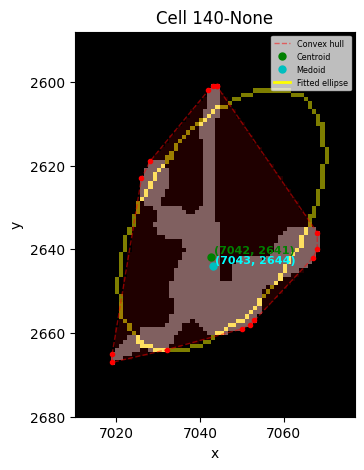

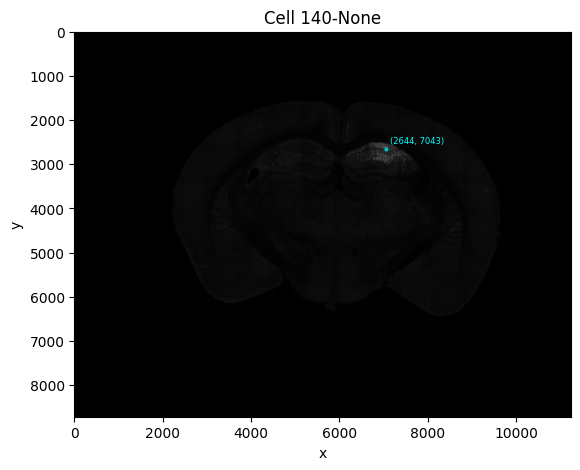

32.30186080932617
{'centroid': (2633.567138671875, 7045.46484375), 'major_axis_length': 38.41929626464844, 'minor_axis_length': 70.29239654541016, 'orientation': 0.563773825643662}
32.30186080932617
0.8374173092019966
0.43830665978316985


In [161]:
branching_cell = np.load("data/branching_component.npy")
cell = Cell(branching_cell, 140)
cell.show()
cell.locate(contrast_gaussian_filtered_img)

params = cell.fit_ellipse()
print(params)

eccentricity = cell.get_eccentricity()
print(eccentricity)
convexity = cell.get_convexity()
print(convexity)

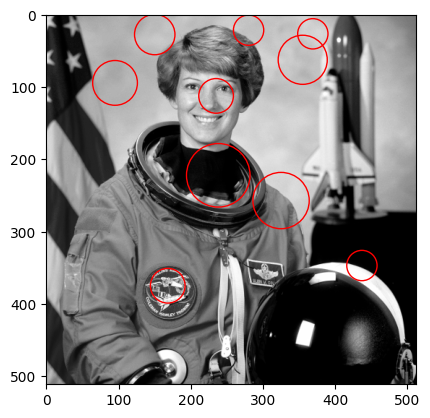

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, color, filters
from skimage.draw import circle_perimeter

# Load an example image
image = color.rgb2gray(data.astronaut())

# Apply a Gaussian filter to smooth the image
smoothed_image = filters.gaussian(image, sigma=2)

# Define the initial circles
num_circles = 10
initial_radius = 20
initial_circles = []
for i in range(num_circles):
    x = np.random.randint(initial_radius, image.shape[1] - initial_radius)
    y = np.random.randint(initial_radius, image.shape[0] - initial_radius)
    initial_circles.append((x, y, initial_radius))

# Define the energy function
def energy_function(circles, image):
    energy = 0
    for x, y, r in circles:
        rr, cc = circle_perimeter(y, x, r)
        rr = np.clip(rr, 0, image.shape[0] - 1)
        cc = np.clip(cc, 0, image.shape[1] - 1)
        energy += np.sum(image[rr, cc])
    return -energy

# Optimize the positions and radii of the circles
def optimize_circles(circles, image, iterations=100, alpha=0.1):
    for _ in range(iterations):
        for i, (x, y, r) in enumerate(circles):
            dx = np.random.randint(-1, 2)
            dy = np.random.randint(-1, 2)
            dr = np.random.randint(-1, 2)
            new_x = np.clip(x + dx, r, image.shape[1] - r)
            new_y = np.clip(y + dy, r, image.shape[0] - r)
            new_r = max(1, r + dr)  # Ensure radius is at least 1
            new_circles = circles.copy()
            new_circles[i] = (new_x, new_y, new_r)
            if energy_function(new_circles, image) < energy_function(circles, image):
                circles[i] = (new_x, new_y, new_r)
    return circles

# Optimize the circles
optimized_circles = optimize_circles(initial_circles, smoothed_image)

# Display the results
fig, ax = plt.subplots()
ax.imshow(image, cmap='gray')

for x, y, r in optimized_circles:
    circ = plt.Circle((x, y), r, color='red', fill=False)
    ax.add_patch(circ)

plt.show()

### Region of interest analysis (dorsal hippocampus dCA1)

Dice Coefficient: 0.504424778761062


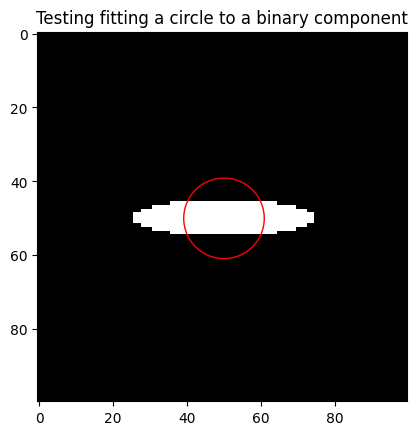

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
from skimage.measure import regionprops, label
from skimage.draw import disk
from matplotlib.patches import Circle
from skimage.draw import ellipse
from matplotlib.patches import Ellipse


def compute_dice_coefficient(binary_image1, binary_image2):
    """
    Compute the Dice coefficient between two binary images.
    
    Parameters:
    - binary_image1: 2D numpy array representing the first binary image.
    - binary_image2: 2D numpy array representing the second binary image.
    
    Returns:
    - dice_coefficient: The Dice coefficient between the two binary images.
    """
    intersection = np.logical_and(binary_image1, binary_image2)
    return 2. * intersection.sum() / (binary_image1.sum() + binary_image2.sum())


def compute_circle_conformity(binary_image):
    """
    Compute how much a connected component in a binary image conforms to a circular shape.
    
    Parameters:
    - binary_image: 2D numpy array representing the binary image.
    
    Returns:
    - dice_coefficient: A measure of how much the connected component conforms to a circular shape.
    """
    # Label the connected components
    labeled_image, num_features = scipy.ndimage.label(binary_image)
    
    # Extract properties of the labeled connected component
    props = regionprops(labeled_image)
    
    if len(props) == 0:
        raise ValueError("No connected component found in the binary image.")
    
    # Assuming we are interested in the largest connected component
    largest_component = max(props, key=lambda x: x.area)
    
    # Get the properties of the largest connected component
    y0, x0 = largest_component.centroid
    equivalent_diameter = largest_component.equivalent_diameter
    
    # Create a binary image of the fitted circle
    fitted_circle = np.zeros_like(binary_image)
    rr, cc = disk((int(y0), int(x0)), int(equivalent_diameter / 2))
    fitted_circle[rr, cc] = 1
    
    # Compute the area of the fitted circle
    #circle_area = np.pi * (equivalent_diameter / 2) ** 2
    
    # Compute the area of the connected component
    #component_area = largest_component.area
    
    # Compute the conformity as the ratio of the component area to the circle area
    #conformity = component_area / circle_area
    
    # Compute the Dice coefficient
    dice_coefficient = compute_dice_coefficient(binary_image, fitted_circle)
    
    return dice_coefficient, (y0, x0, equivalent_diameter)

# Example usage
binary_image = np.zeros((100, 100), dtype=np.uint8)
rr, cc = ellipse(50, 50, 5, 25)
binary_image[rr, cc] = 1

dice_coefficient, circle_params = compute_circle_conformity(binary_image)
print(f"Dice Coefficient: {dice_coefficient}")

# Plot the binary image and the fitted circle
y0, x0, equivalent_diameter = circle_params
fig, ax = plt.subplots()
ax.imshow(binary_image, cmap='gray')

# Draw the fitted circle
circle_patch = Circle((x0, y0), equivalent_diameter / 2, edgecolor='red', facecolor='none')
ax.add_patch(circle_patch)

plt.title('Testing fitting a circle to a binary component')
plt.show()

### Run cell counting

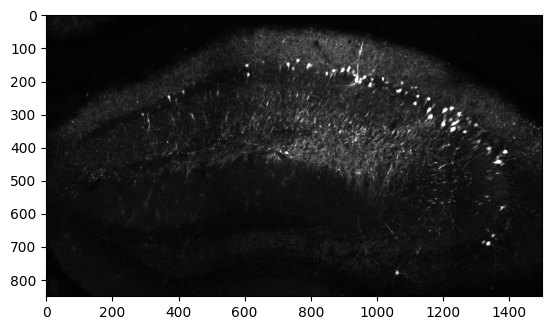

Peaks shape: (326, 2)
Peaks: [[ 195  939]
 [ 446 1369]
 [ 329 1234]
 [ 191  963]
 [ 213  980]
 [ 151  731]
 [ 169  897]
 [ 327  920]
 [ 291 1206]
 [ 171  870]
 [ 415 1388]
 [ 288 1158]
 [ 332 1202]
 [ 229 1070]
 [ 255 1158]
 [ 308 1165]
 [ 692 1336]
 [ 343 1232]
 [ 162  917]
 [ 284 1227]
 [ 178  849]
 [ 270 1115]
 [ 355  890]
 [ 584 1379]
 [ 138  764]
 [ 244  760]
 [ 299 1250]
 [ 247 1123]
 [ 153  795]
 [ 381  936]
 [ 356  814]
 [ 418  727]
 [ 195 1019]
 [ 204  952]
 [ 102  954]
 [ 414  709]
 [ 355 1266]
 [ 254  792]
 [ 326  813]
 [ 430  741]
 [ 155  943]
 [ 410 1103]
 [ 480  946]
 [ 469  886]
 [ 432 1062]
 [ 196  951]
 [ 322  771]
 [ 184  611]
 [ 477  976]
 [ 355 1064]
 [ 111  952]
 [ 155  606]
 [ 335  855]
 [ 271  668]
 [ 371  938]
 [ 118  949]
 [ 197  987]
 [ 468  983]
 [ 385  926]
 [ 463 1191]
 [ 405  674]
 [ 264  277]
 [ 479 1365]
 [ 344  954]
 [ 406 1341]
 [ 320  309]
 [ 248  371]
 [ 338  829]
 [ 319 1224]
 [ 347  962]
 [ 207 1077]
 [ 315  813]
 [ 433 1089]
 [ 331 1415]
 [ 413 10

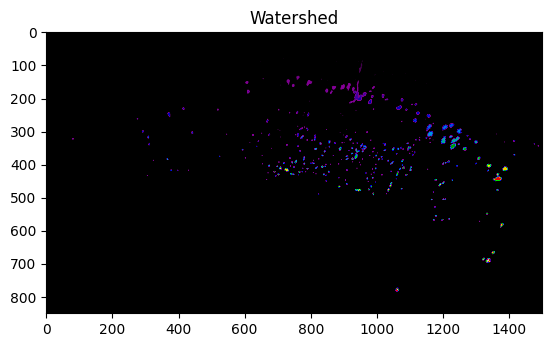

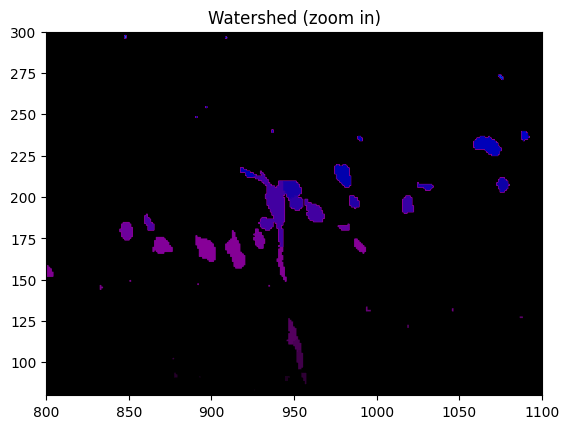

Sizes shape: (326,)
Sizes: [  2.   1.  11.   1.   7.   5.  15.   5.   1.  40.  27.  62.   2.   2.
   5.   2.  83.   9.   4.   1.   1.   2.   1.  97. 163.  56.  56.   1.
   2. 145.  47. 128.  36.  86.  55.  68.  10.   9.  57.  36. 105. 358.
  62.  58.  37.  94.  28.  48.   1. 103.  27.  27.  10. 130.  26.   7.
  10.   7.  21.   2.  23.   5.   2.  58.  57.   1.   1.  31.   1.  74.
   7.   1.  88.  26.   5.   5. 111.   2. 142.   3. 164.   8.   1.   1.
  13.  18.   2. 139.   1.  16.   3.   7.   1.  17.   2. 185.   1.   2.
   9.   3.   9.  28.   1.  17.   9.  17.   1.  41.  17.   2.  34.  10.
   5.   5.  12.  23.  20.   7.   5.   6.   1.   6.   3. 205.  10.   5.
 184.  58.   1.  30.   3.   1.   3.   1.  12.   5.  19.   3.   9.   4.
  22.  11.   9.   7.   4. 184.  27.   3.   4.   8.  32.   6.  49.   1.
   4.   1.  12.   9.  46.   6.  13.  17.   3.  66.  22.   6.  35.  19.
  14.   3.   8.  13.  32.   8.   1.   4.   5.   1.   2.  10.   5.  13.
   6.   8.  10.   1.   2.   2.   9.   4.  10.   7.

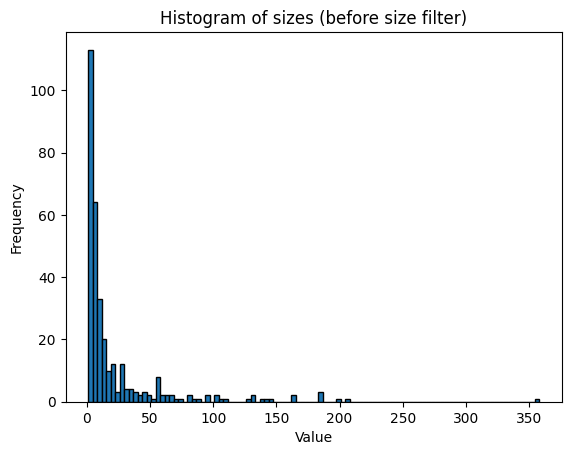

cells: [[  82  717]
 [  90  956]
 [ 101  953]
 [ 110  952]
 [ 117  948]
 [ 139  761]
 [ 151  731]
 [ 155  794]
 [ 154  607]
 [ 159  942]
 [ 165  915]
 [ 163  747]
 [ 168  896]
 [ 169  989]
 [ 170  870]
 [ 174  928]
 [ 178  848]
 [ 181  982]
 [ 181  611]
 [ 183  862]
 [ 190  962]
 [ 194  938]
 [ 194 1018]
 [ 196  951]
 [ 196  986]
 [ 204  948]
 [ 206 1029]
 [ 207 1076]
 [ 212  979]
 [ 214  921]
 [ 220 1118]
 [ 221 1106]
 [ 230 1067]
 [ 233  415]
 [ 236  519]
 [ 236 1089]
 [ 244  759]
 [ 247 1123]
 [ 250  371]
 [ 251  792]
 [ 255 1156]
 [ 269 1115]
 [ 270  668]
 [ 283 1226]
 [ 288 1157]
 [ 290 1205]
 [ 295  768]
 [ 295  789]
 [ 301 1249]
 [ 302  292]
 [ 305  441]
 [ 309 1162]
 [ 312  761]
 [ 315  812]
 [ 317  908]
 [ 318 1224]
 [ 319  308]
 [ 319  773]
 [ 321 1150]
 [ 324 1281]
 [ 325  812]
 [ 326  920]
 [ 328 1235]
 [ 330 1415]
 [ 330 1201]
 [ 333 1299]
 [ 333  856]
 [ 337  873]
 [ 338  829]
 [ 341 1024]
 [ 340 1247]
 [ 346 1230]
 [ 344  953]
 [ 347  963]
 [ 352 1097]
 [ 352  925]
 [ 35

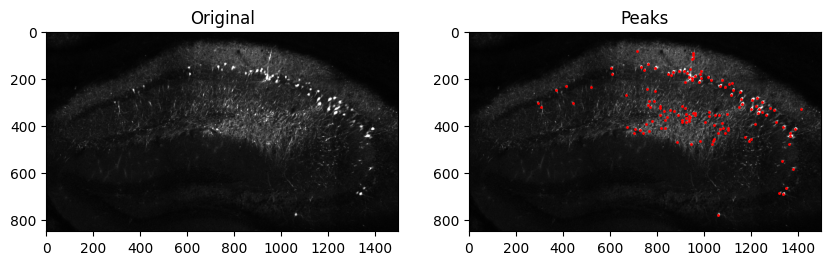

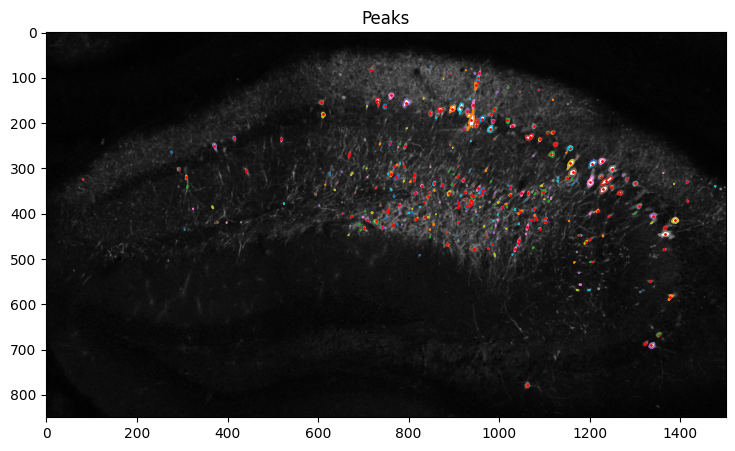

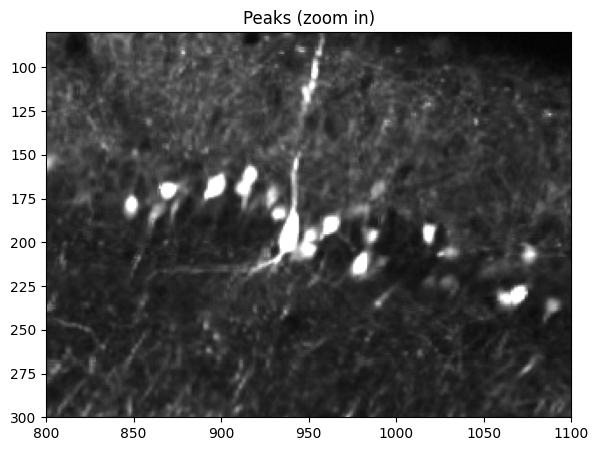

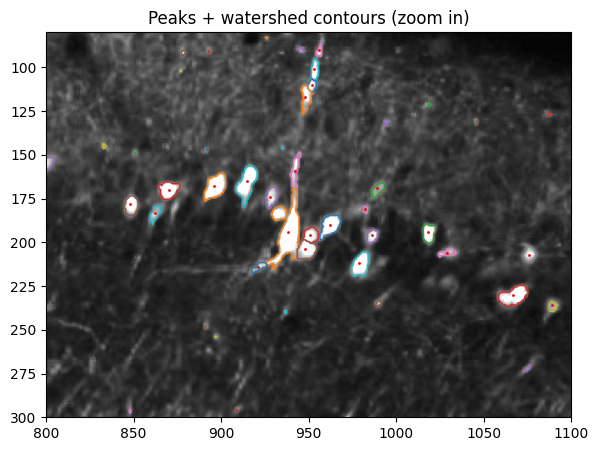

In [81]:
# Parameters
min_distance = 5  # 5
intensity_threshold = 10  # 10
size_threshold = 10  # 30

count_roi = curr_roi.copy()

plt.imshow(curr_roi_contrast, cmap='gray')
plt.show()

# Normalize
count_roi = (count_roi/np.iinfo(count_roi.dtype).max)*255
count_roi = count_roi.astype(np.uint8)




peaks = peak_local_max(count_roi, min_distance=min_distance, threshold_abs=intensity_threshold)
#peaks = peak_local_max(count_roi, min_distance=min_distance, threshold_rel=0.1)


print("Peaks shape:", peaks.shape)
print("Peaks:", peaks)

mask = np.zeros(count_roi.shape)
mask[tuple(peaks.T)] = True
markers, _ = scipy.ndimage.label(mask)
print("markers")
print(markers)

# Size detection
watershed_mask = count_roi > intensity_threshold
labels = watershed(-count_roi, markers, mask = watershed_mask)

plt.imshow(labels, cmap='nipy_spectral')
plt.title("Watershed")
plt.show()

plt.imshow(labels, cmap='nipy_spectral')
plt.xlim(800, 1100)
plt.ylim(80, 300)
plt.title("Watershed (zoom in)")
plt.show()

# Compute the center of mass of each cell
centers = np.array(scipy.ndimage.center_of_mass(count_roi, labels, index=np.arange(1, np.max(labels) + 1)))
centers = centers.astype(int)

#print("Centers shape:", centers.shape)
#print("Centers:", centers)

# Filter out small cells
sizes = scipy.ndimage.sum(np.ones(labels.shape, dtype=bool), labels=labels, index=np.arange(1, np.max(labels) + 1))
print("Sizes shape:", sizes.shape)
print("Sizes:", sizes)

# Plot the histogram
plt.hist(sizes, bins=100, edgecolor='black')

# Add titles and labels
plt.title('Histogram of sizes (before size filter)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

cells = centers[sizes >= size_threshold]
print("cells:", cells)

intensity_stats(count_roi)

# Show the region of interest with the detected peaks
plt.figure(figsize=(10, 5))  # 20, 10
plt.subplot(1, 2, 1)
plt.imshow(curr_roi_contrast, cmap='gray')
plt.title("Original")
plt.subplot(1, 2, 2)
for p in cells:
    plt.plot(p[1], p[0], 'ro', markersize=1)
plt.imshow(curr_roi_contrast, cmap='gray')
plt.title("Peaks")
plt.show()




# Function to remove small connected components
def remove_small_components(binary_image, min_size):
    # Label the connected components
    labeled_image, num_features = scipy.ndimage.label(binary_image)
    
    # Compute the size of each connected component
    component_sizes = scipy.ndimage.sum(binary_image, labeled_image, range(num_features + 1))
    
    # Create a mask to keep only the components larger than min_size
    size_mask = component_sizes >= min_size
    
    # Remove small components
    filtered_image = size_mask[labeled_image]
    
    return filtered_image


# WS label show
ws_labels = labels.copy()
#ws_labels[ws_labels != 0] = 1
#ws_labels = remove_small_components(ws_labels, size_threshold)

# Find contours for each unique label in the watershed output
from skimage.measure import find_contours
contours = []
for label in np.unique(ws_labels):
    if label == 0:
        continue  # Skip the background
    contours.extend(find_contours(ws_labels == label, 0.5))

"""
ws_mask = np.zeros(count_roi.shape)
print("centers")
print(centers)
ws_mask[tuple(centers.T)] = True
ws_markers, _ = scipy.ndimage.label(ws_mask)
ws_labels = watershed(-count_roi, ws_markers, mask = watershed_mask)
ws_labels[ws_labels != 0] = 1
plt.imshow(ws_labels, cmap='nipy_spectral')
plt.show()
"""




# Show the region of interest with the detected peaks
plt.figure(figsize=(10, 5))  # 20, 10
plt.imshow(curr_roi_contrast, cmap='gray')
#plt.contour(ws_labels, colors='green', linewidths=1)

# Plot each contour with a different color
for contour in contours:
    plt.plot(contour[:, 1], contour[:, 0], linewidth=1)


for p in cells:
    plt.plot(p[1], p[0], 'ro', markersize=1)
plt.title("Peaks")
plt.show()

# Just the zoomed in contrast by itself
plt.figure(figsize=(10, 5))  # 20, 10
plt.imshow(curr_roi_contrast, cmap='gray')
plt.title("Peaks (zoom in)")
plt.xlim(800, 1100)
plt.ylim(300, 80)

# Show the region of interest with the detected peaks (zoomed in)
plt.figure(figsize=(10, 5))  # 20, 10
plt.imshow(curr_roi_contrast, cmap='gray')
#plt.contour(ws_labels, colors='green', linewidths=1)

# Plot each contour with a different color
for contour in contours:
    plt.plot(contour[:, 1], contour[:, 0], linewidth=1)

for p in cells:
    plt.plot(p[1], p[0], 'ro', markersize=1)
plt.title("Peaks + watershed contours (zoom in)")
plt.xlim(800, 1100)
plt.ylim(300, 80)
plt.show()

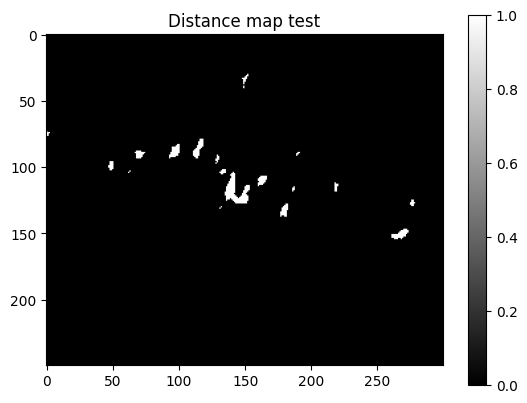

In [12]:
dmap = scipy.ndimage.distance_transform_edt(ws_labels)
dmap = dmap[80:330, 800:1100]
#thresh = np.percentile(dmap, 90)
#print("thresh:", thresh)
dmap = dmap > 2

plt.imshow(dmap, cmap='gray')
plt.colorbar()
plt.title('Distance map test')
plt.show()

In [13]:
### Ground truth analysis
print(gt140.shape)
print(gt140)

(66, 2)
[[2747.81341415 6393.47268444]
 [2695.88137939 6469.8433238 ]
 [2681.62552671 6513.62915703]
 [2601.18178659 6706.0831682 ]
 [2630.71176714 6711.17454416]
 [2590.99903467 6756.99692777]
 [2596.09041063 6831.33101674]
 [2611.3645385  6849.65997019]
 [2586.92593391 6859.8427221 ]
 [2861.86023558 7487.10024   ]
 [2626.63866637 6949.45093894]
 [2616.45591446 6969.81644277]
 [2618.49246484 7012.58400081]
 [2615.43763927 6995.27332256]
 [2619.28170464 7027.41990821]
 [2631.55880636 7032.19433666]
 [2645.8820917  7038.33288752]
 [2654.74888738 7048.56380562]
 [2645.20003049 7049.92792803]
 [2637.69735722 7062.88709096]
 [2645.20003049 7084.71304957]
 [2660.88743824 7079.25655992]
 [2617.91758222 7088.1233556 ]
 [2642.47178566 7117.45198749]
 [2680.66721323 7161.10390471]
 [2678.62102961 7169.9707004 ]
 [2654.74888738 7175.42719005]
 [2684.75958047 7189.06841418]
 [2669.75423393 7205.43788314]
 [2668.39011151 7217.03292365]
 [2694.99049857 7223.85353572]
 [2717.49851839 7214.98674003]


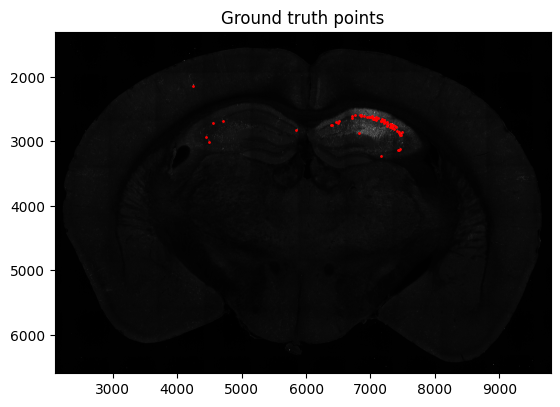

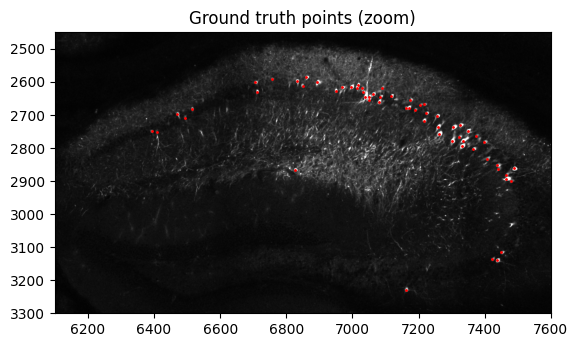

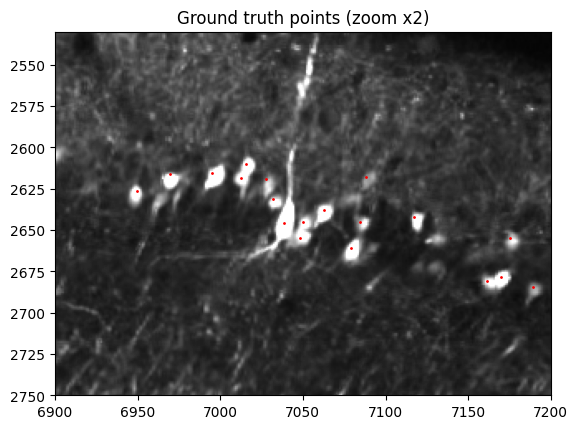

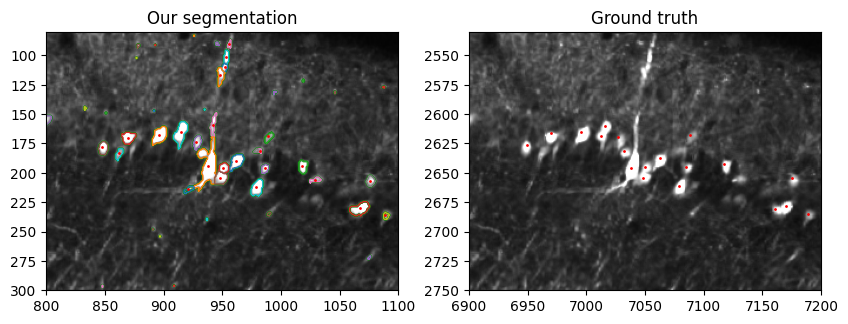

In [83]:
# Show the ground truth points on the contrasted section
plt.imshow(curr_contrast, cmap='gray')
plt.title("Ground truth points")
for p in gt140:
    plt.plot(p[1], p[0], 'ro', markersize=1)
plt.xlim(x_section_boundary)
plt.ylim(y_section_boundary[::-1])
plt.show()

# Zoom in
plt.imshow(curr_contrast, cmap='gray')
plt.title("Ground truth points (zoom)")
for p in gt140:
    plt.plot(p[1], p[0], 'ro', markersize=1)
plt.xlim(x_roi_boundary)
plt.ylim(y_roi_boundary[::-1])
plt.show()

# Zoom in further
plt.imshow(curr_contrast, cmap='gray')
plt.title("Ground truth points (zoom x2)")
for p in gt140:
    plt.plot(p[1], p[0], 'ro', markersize=1)
#plt.xlim(800, 1100)
#plt.ylim(80, 300)
plt.xlim(x_roi_boundary[0] + 800, x_roi_boundary[0] + 1100)
plt.ylim(y_roi_boundary[0] + 300, y_roi_boundary[0] + 80)
plt.show()


# Show our segmentation and ground truth
plt.figure(figsize=(10, 5))  # 20, 10

plt.subplot(1, 2, 1)
# Show the region of interest with the detected peaks (zoomed in)
plt.imshow(curr_roi_contrast, cmap='gray')
plt.contour(ws_labels, colors='green', linewidths=1)

# Plot each contour with a different color
for contour in contours:
    plt.plot(contour[:, 1], contour[:, 0], linewidth=1)

for p in cells:
    plt.plot(p[1], p[0], 'ro', markersize=1)
plt.title("Our segmentation")
plt.xlim(800, 1100)
plt.ylim(300, 80)

plt.subplot(1, 2, 2)
plt.imshow(curr_contrast, cmap='gray')
plt.title("Ground truth")
for p in gt140:
    plt.plot(p[1], p[0], 'ro', markersize=1)
#plt.xlim(800, 1100)
#plt.ylim(80, 300)
plt.xlim(x_roi_boundary[0] + 800, x_roi_boundary[0] + 1100)
plt.ylim(y_roi_boundary[0] + 300, y_roi_boundary[0] + 80)
plt.show()

### Experiment with Delaunay triangulation

https://scikit-image.org/docs/stable/auto_examples/applications/plot_human_mitosis.html

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
from scipy.spatial import Delaunay, ConvexHull
from skimage.draw import disk
from sklearn.cluster import DBSCAN

# Function to get the points on the convex hull of a binary image
def convex_hull_points(binary_image):
    """
    Get the points on the convex hull of a binary image.
    
    Parameters:
    - binary_image: 2D numpy array representing the binary image.
    
    Returns:
    - hull_points: Coordinates of the points on the convex hull.
    """
    # Extract the coordinates of the foreground pixels
    points = np.column_stack(np.nonzero(binary_image))
    
    # Compute the convex hull
    hull = ConvexHull(points)
    
    # Get the coordinates of the points on the convex hull
    hull_points = points[hull.vertices]
    
    return hull_points


# Function to perform Delaunay triangulation on a binary image
def delaunay_triangulation(binary_image):
    """
    Perform Delaunay triangulation on a binary image.
    
    Parameters:
    - binary_image: 2D numpy array representing the binary image.
    
    Returns:
    - tri: Delaunay triangulation object.
    """
    # Extract the coordinates of the foreground pixels
    #hull_points = convex_hull_points(binary_image)
    points = get_boundary_points(binary_image)
    
    #points = hull_points[::2]
    #points = np.column_stack(np.nonzero(binary_image))
    #points = points[::200]
    
    # Perform Delaunay triangulation
    tri = Delaunay(points)
    
    # Filter triangles to keep only those within the binary image
    #centroids = np.mean(tri.points[tri.simplices], axis=1)
    #mask = binary_image[centroids[:, 0].astype(int), centroids[:, 1].astype(int)]
    #filtered_simplices = tri.simplices[mask]
    
    return tri


# Function to get the boundary points of a binary image
def get_boundary_points(binary_image):
    """
    Get the boundary points of a binary image.
    
    Parameters:
    - binary_image: 2D numpy array representing the binary image.
    
    Returns:
    - boundary_points: Coordinates of the boundary points.
    """
    contours = find_contours(binary_image, level=0.5)
    boundary_points = np.vstack(contours)
    return boundary_points

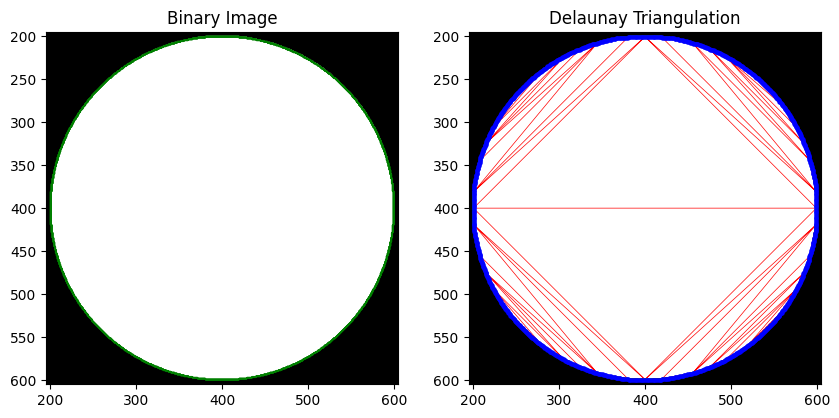

In [98]:
# Example usage
binary_image = np.zeros((800, 800), dtype=np.uint8)
rr, cc = disk((400, 400), 200)
binary_image[rr, cc] = 1
binary_circle = binary_image.copy()

# Perform Delaunay triangulation
tri = delaunay_triangulation(binary_image)
hull_points = convex_hull_points(binary_image)
boundary_points = get_boundary_points(binary_image)

# Plot the binary image and the Delaunay triangulation
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(binary_image, cmap='gray')
plt.contour(binary_image, colors='green', linewidths=1)
plt.title('Binary Image')
plt.xlim(195, 605)
plt.ylim(605, 195)

plt.subplot(1, 2, 2)
plt.imshow(binary_image, cmap='gray')
plt.contour(binary_image, colors='green', linewidths=1)
plt.triplot(tri.points[:, 1], tri.points[:, 0], tri.simplices, color='red', linewidth=0.5)
plt.plot(boundary_points[:, 1], boundary_points[:, 0], 'bo', markersize=2)
plt.title('Delaunay Triangulation')
plt.xlim(195, 605)
plt.ylim(605, 195)


plt.show()

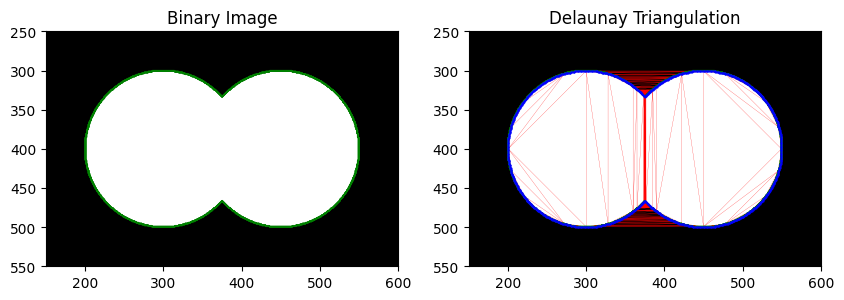

In [46]:
# Try with two cells conjoined together
binary_image = np.zeros((800, 800), dtype=np.uint8)
rr, cc = disk((400, 300), 100)
rr2, cc2 = disk((400, 450), 100)

binary_image[rr, cc] = 1
binary_image[rr2, cc2] = 1


# Perform Delaunay triangulation
tri = delaunay_triangulation(binary_image)
#hull_points = convex_hull_points(binary_image)
boundary_points = get_boundary_points(binary_image)

# Plot the binary image and the Delaunay triangulation
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(binary_image, cmap='gray')
plt.contour(binary_image, colors='green', linewidths=1)
plt.title('Binary Image')
plt.xlim(150, 600); plt.ylim(550, 250)

plt.subplot(1, 2, 2)
plt.imshow(binary_image, cmap='gray')
plt.contour(binary_image, colors='green', linewidths=1)
plt.triplot(tri.points[:, 1], tri.points[:, 0], tri.simplices, color='red', linewidth=0.15)
plt.plot(boundary_points[:, 1], boundary_points[:, 0], 'bo', markersize=0.5)
plt.title('Delaunay Triangulation')
plt.xlim(150, 600); plt.ylim(550, 250)



plt.show()

/tmp/ipykernel_26927/412382972.py:88: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))


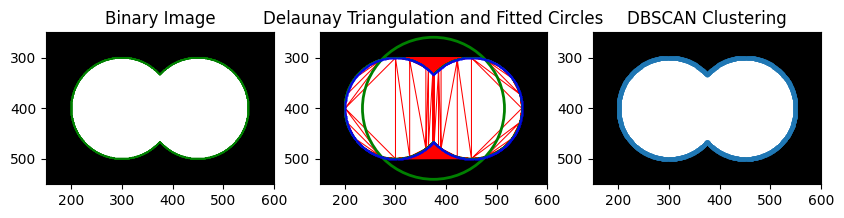

In [104]:
# Function to fit a circle to a set of points
def fit_circle(points):
    """
    Fit a circle to a set of points using the least squares method.
    
    Parameters:
    - points: 2D numpy array of shape (n_points, 2) representing the coordinates of the points.
    
    Returns:
    - center: Coordinates of the center of the fitted circle.
    - radius: Radius of the fitted circle.
    """
    x = points[:, 0]
    y = points[:, 1]
    A = np.column_stack([x, y, np.ones_like(x)])
    b = x**2 + y**2
    c = np.linalg.lstsq(A, b, rcond=None)[0]
    center = c[:2] / 2
    radius = np.sqrt(c[2] + center[0]**2 + center[1]**2)
    return center, radius

# Example usage
binary_image = np.zeros((800, 800), dtype=np.uint8)
rr, cc = disk((400, 300), 100)
rr2, cc2 = disk((400, 450), 100)

binary_image[rr, cc] = 1
binary_image[rr2, cc2] = 1

# Perform Delaunay triangulation
tri = delaunay_triangulation(binary_image)
boundary_points = get_boundary_points(binary_image)

# Cluster the points using DBSCAN
#points = np.column_stack(np.nonzero(binary_image))
points = boundary_points
clustering = DBSCAN(eps=20, min_samples=10).fit(points)
labels = clustering.labels_

# Fit circles to the clusters
unique_labels = np.unique(labels)
circles = []
for label in unique_labels:
    if label == -1:
        continue  # Skip noise points
    cluster_points = points[labels == label]
    center, radius = fit_circle(cluster_points)
    circles.append((center, radius))

# Plot the binary image, Delaunay triangulation, and fitted circles
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(binary_image, cmap='gray')
plt.contour(binary_image, colors='green', linewidths=1)
plt.title('Binary Image')
plt.xlim(150, 600); plt.ylim(550, 250)

plt.subplot(1, 3, 2)
plt.imshow(binary_image, cmap='gray')
plt.contour(binary_image, colors='green', linewidths=1)
plt.plot(boundary_points[:, 1], boundary_points[:, 0], 'bo', markersize=0.25)
plt.triplot(tri.points[:, 1], tri.points[:, 0], tri.simplices, color='red', linewidth=0.75)
for center, radius in circles:
    circle = plt.Circle((center[1], center[0]), radius, color='green', fill=False, linewidth=2)
    plt.gca().add_patch(circle)
plt.title('Delaunay Triangulation and Fitted Circles')
plt.xlim(150, 600); plt.ylim(550, 250)


# 3
"""
plt.subplot(1, 3, 3)
placeholder = np.zeros(binary_image.shape)
plt.imshow(placeholder, cmap='gray')
#plt.imshow(binary_image, cmap='gray')
#plt.plot(tri.points[:, 1], tri.points[:, 0], 'ro', markersize=0.25)
plt.triplot(tri.points[:, 1], tri.points[:, 0], tri.simplices, color='red', linewidth=0.15)
plt.title('Delaunay Triangulation points')
plt.xlim(150, 600); plt.ylim(550, 250)
"""


# Plot the DBSCAN clustering result
plt.subplot(1, 3, 3)
plt.imshow(binary_image, cmap='gray')
plt.contour(binary_image, colors='green', linewidths=1)
unique_labels = np.unique(labels)
colors = plt.cm.get_cmap('tab10', len(unique_labels))
for label in unique_labels:
    if label == -1:
        color = 'k'  # Black for noise
    else:
        color = colors(label)
    cluster_points = points[labels == label]
    plt.plot(cluster_points[:, 1], cluster_points[:, 0], 'o', markerfacecolor=color, markersize=2)
plt.title('DBSCAN Clustering')
plt.xlim(150, 600); plt.ylim(550, 250)

plt.show()


plt.show()

median distance: 4.123105625617661
average distance: 22.169972459554597


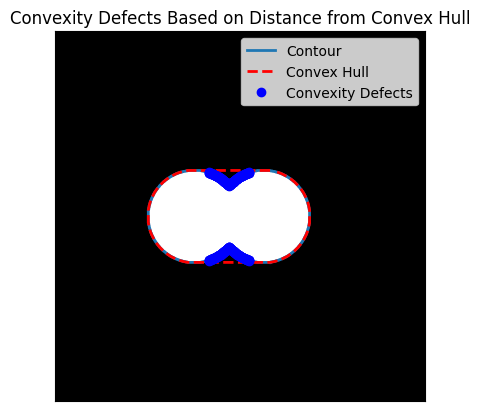

In [105]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import io, color, measure
from scipy.spatial import ConvexHull, distance

# Threshold the image
binary = binary_image

# Find contours using skimage
contours = measure.find_contours(binary, level=0.5)

# Assuming the largest contour corresponds to the conjoined circles
main_contour = max(contours, key=len)

# Convert the contour to (x, y) coordinates
main_contour = np.array(main_contour)

# Calculate the convex hull of the contour
hull = ConvexHull(main_contour)

# Identify convexity defects (points not on the convex hull)
hull_points = main_contour[hull.vertices]

# Function to calculate the minimum distance from a point to a set of points
def point_to_hull_distance(point, hull_points):
    return np.min(distance.cdist([point], hull_points))

# Calculate distances from each contour point to the convex hull
distances = np.array([point_to_hull_distance(point, hull_points) for point in main_contour])

# Define a threshold for "defects" based on distance from the convex hull
median_distance = np.median(distances)
average_distance = np.mean(distances)
print("median distance:", median_distance)
print("average distance:", average_distance)
distance_threshold = 2 * average_distance #  15  # Adjust based on your specific image (higher values for larger distances)
defect_points = main_contour[distances > distance_threshold]

# Plot the original image and contours
fig, ax = plt.subplots()
ax.imshow(binary, cmap=plt.cm.gray)

# Plot the main contour
ax.plot(main_contour[:, 1], main_contour[:, 0], linewidth=2, label='Contour')

# Plot the convex hull
ax.plot(hull_points[:, 1], hull_points[:, 0], 'r--', lw=2, label='Convex Hull')

# Plot the defect points (concave points where the circles might be joined)
ax.plot(defect_points[:, 1], defect_points[:, 0], 'bo', label='Convexity Defects')

# Add legend and titles
ax.legend()
ax.set_title('Convexity Defects Based on Distance from Convex Hull')
ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])

plt.show()